# MapLibreによる描画のためのgeoJSONを作成

In [1]:
import json
import statistics
from collections import Counter

import pandas as pd

In [2]:
with open("../data/people_for_map.json") as fp:
    people_for_map = json.load(fp)
len(people_for_map)

1560

## 市区町村ごとの人物

### 概要文や名前の前処理

In [3]:
def abbr_text(text, maxlen=140):
    if len(text) <= maxlen:
        return text
    return text[:maxlen-1] + "…"

In [4]:
for p in people_for_map:
    p["name"] = p["page"].replace("_", " ").split("(")[0]
    p["url"] = f"https://ja.wikipedia.org/wiki/{p['page']}"
    p["desc"] = abbr_text(p["abstract"])

### PV数

In [5]:
sorted_views = sorted([(p["views"]) for p in people_for_map], reverse=True)
len(sorted_views)

1560

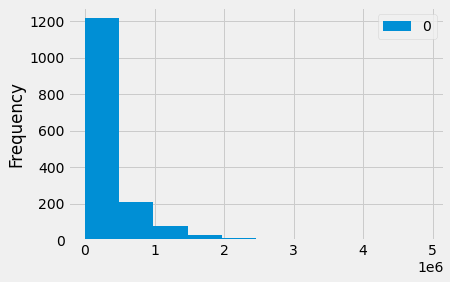

In [6]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')
df = pd.DataFrame(sorted_views).plot.hist();

In [7]:
d = {
    "max": max(sorted_views),
    "mean": statistics.mean(sorted_views),
    "median": statistics.median(sorted_views),
    "min": min(sorted_views)
}

for k, v in d.items():
    print(f"{k:}: \t {round(v):,}")

max: 	 4,914,419
mean: 	 344,350
median: 	 165,016
min: 	 659


In [8]:
ref_large = 1_000_000
ref_medium = 100_000

def categorize_views(views):
    if views > ref_large:
        return "lg"
    elif views > ref_medium:
        return "md"
    return "sm"

Counter([categorize_views(v) for v in sorted_views])

Counter({'lg': 127, 'md': 798, 'sm': 635})

In [9]:
features = []
for p in people_for_map:
        feat = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": p["coords"]
            },
            "properties": {
                "group": categorize_views(p["views"]),
                "person": p["name"],
                "pref": p["pref"],
                "munic": p["munic"],
                "desc": p["desc"],
                "url": p["url"]
            }
        }
        features.append(feat)

len(features)

1560

## ページがひとつもなかった市区町村

In [10]:
with open("../data/pref_munic_pages.json") as fp:
    pref_munic_pages = json.load(fp)

with open("../data/pref_munic_coords.json") as fp:
    pref_munic_coords = json.load(fp)

In [11]:
zero_page_locations = []

for pref, munic_pages in pref_munic_pages.items():
    for munic, pages in munic_pages.items():
        if not pages:
            zero_page_locations.append( (pref, munic) )

len(zero_page_locations)

336

In [12]:
zero_page_locations

[('北海道', '札幌市中央区'),
 ('北海道', '石狩郡新篠津村'),
 ('北海道', '松前郡福島町'),
 ('北海道', '檜山郡江差町'),
 ('北海道', '檜山郡上ノ国町'),
 ('北海道', '檜山郡厚沢部町'),
 ('北海道', '爾志郡乙部町'),
 ('北海道', '島牧郡島牧村'),
 ('北海道', '寿都郡寿都町'),
 ('北海道', '寿都郡黒松内町'),
 ('北海道', '磯谷郡蘭越町'),
 ('北海道', '虻田郡留寿都村'),
 ('北海道', '虻田郡京極町'),
 ('北海道', '虻田郡倶知安町'),
 ('北海道', '積丹郡積丹町'),
 ('北海道', '古平郡古平町'),
 ('北海道', '余市郡仁木町'),
 ('北海道', '空知郡南幌町'),
 ('北海道', '空知郡奈井江町'),
 ('北海道', '空知郡上砂川町'),
 ('北海道', '夕張郡長沼町'),
 ('北海道', '樺戸郡月形町'),
 ('北海道', '樺戸郡浦臼町'),
 ('北海道', '雨竜郡秩父別町'),
 ('北海道', '雨竜郡北竜町'),
 ('北海道', '上川郡比布町'),
 ('北海道', '上川郡愛別町'),
 ('北海道', '空知郡上富良野町'),
 ('北海道', '空知郡中富良野町'),
 ('北海道', '勇払郡占冠村'),
 ('北海道', '上川郡下川町'),
 ('北海道', '中川郡音威子府村'),
 ('北海道', '雨竜郡幌加内町'),
 ('北海道', '苫前郡苫前町'),
 ('北海道', '苫前郡初山別村'),
 ('北海道', '天塩郡遠別町'),
 ('北海道', '枝幸郡中頓別町'),
 ('北海道', '天塩郡豊富町'),
 ('北海道', '利尻郡利尻町'),
 ('北海道', '利尻郡利尻富士町'),
 ('北海道', '天塩郡幌延町'),
 ('北海道', '網走郡津別町'),
 ('北海道', '斜里郡清里町'),
 ('北海道', '斜里郡小清水町'),
 ('北海道', '常呂郡訓子府町'),
 ('北海道', '紋別郡遠軽町'),
 ('北海道', '紋別郡滝上町'),
 ('北海道', '紋別郡興部町'),
 ('北海道', '紋別郡雄武町')

In [13]:
for pref, munic in zero_page_locations:
        feat = {
            "type": "Feature",
            "geometry": {
                "type": "Point",
                "coordinates": pref_munic_coords[pref][munic]
            },
            "properties": {
                "group": "na",
                "pref": pref,
                "munic": munic
            }
        }
        features.append(feat)

len(features)

1896

In [14]:
assert len(features) == sum([len(x) for x in pref_munic_coords.values()])

In [15]:
geojson = {
    "type": "FeatureCollection",
    "features": features
}
with open("../../public/people.geojson", "w") as fp:
    json.dump(geojson, fp, ensure_ascii=False)